In [24]:
import numpy as np
import pandas as pd

In [25]:
df = pd.read_csv("continuousDataset.csv")
print(df.dtypes)

datetime       object
nat_demand    float64
T2M_toc       float64
QV2M_toc      float64
TQL_toc       float64
W2M_toc       float64
T2M_san       float64
QV2M_san      float64
TQL_san       float64
W2M_san       float64
T2M_dav       float64
QV2M_dav      float64
TQL_dav       float64
W2M_dav       float64
Holiday_ID      int64
holiday         int64
school          int64
dtype: object


In [26]:
df = pd.read_csv('continuousDataset.csv', parse_dates=['datetime'])
print(df.dtypes)

datetime      datetime64[ns]
nat_demand           float64
T2M_toc              float64
QV2M_toc             float64
TQL_toc              float64
W2M_toc              float64
T2M_san              float64
QV2M_san             float64
TQL_san              float64
W2M_san              float64
T2M_dav              float64
QV2M_dav             float64
TQL_dav              float64
W2M_dav              float64
Holiday_ID             int64
holiday                int64
school                 int64
dtype: object


In [27]:
''' Weather Features given for 3 cities 
   toc -> Tocumen
   san -> San Miguelito
   dav -> David
   features are
   T2M->temperature
   QV2M->humidity
   TQL->precipitation
   W2M->wind speed
   data available for holiday in city and opening of schools.
   consumtion will be less on holiday and when school is closed 
'''

' Weather Features given for 3 cities \n   toc -> Tocumen\n   san -> San Miguelito\n   dav -> David\n   features are\n   T2M->temperature\n   QV2M->humidity\n   TQL->precipitation\n   W2M->wind speed\n   data available for holiday in city and opening of schools.\n   consumtion will be less on holiday and when school is closed \n'

In [28]:
# Select features and target
features = [
    'T2M_toc','QV2M_toc','TQL_toc','W2M_toc',
    'T2M_san','QV2M_san','TQL_san','W2M_san',
    'T2M_dav','QV2M_dav','TQL_dav','W2M_dav',
    'Holiday_ID','holiday','school'
]
target = 'nat_demand'

In [29]:
from sklearn.preprocessing import MinMaxScaler
# Scale features and target
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

In [30]:
from sklearn.model_selection import train_test_split
# Create sequences for time series
def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        xs.append(X[i:(i+seq_length)])
        ys.append(y[i+seq_length])
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24       # For 24 Hours
X_seq, y_seq = create_sequences(X, y, SEQ_LENGTH)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [31]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 64

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Model Architecture
INPUT_SIZE = len(features)
HIDDEN_SIZE = 256
NUM_LAYERS = 4
OUTPUT_SIZE = 1
DROPOUT = 0.4

model = GRUModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, dropout=DROPOUT)

In [33]:
device = torch.device('cpu')
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        # Learning Rate (lr)

EPOCHS = 50       # Number of Epochs

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}')

KeyboardInterrupt: 

In [20]:
#this is GRU model continued
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch)
        predictions.append(output.cpu().numpy())
        actuals.append(y_batch.numpy())
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverse transform to original scale
predictions = scaler_y.inverse_transform(predictions)
actuals = scaler_y.inverse_transform(actuals)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actuals, predictions)
print(f'Test MSE: {mse:.2f}')

from sklearn.metrics import mean_absolute_percentage_error

mape_gru = mean_absolute_percentage_error(actuals, predictions)
accuracy_gru = 100 * (1 - mape_gru)
print(f"GRU Model Accuracy (t+1): {accuracy_gru:.2f}%")

Test MSE: 22348.43
GRU Model Accuracy (t+1): 90.34%


In [23]:
#for lstm
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)        # LSTM returns (output, (h_n, c_n))
        out = out[:, -1, :]          # Use output from last time step
        out = self.fc(out)           # Fully connected output
        return out
INPUT_SIZE = len(features)
HIDDEN_SIZE = 256
NUM_LAYERS = 4
OUTPUT_SIZE = 1
DROPOUT = 0.4

lstm_model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, dropout=DROPOUT)
lstm_model = lstm_model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
EPOCHS = 50

for epoch in range(EPOCHS):
    lstm_model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = lstm_model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}")


Epoch 10/50, Loss: 0.0038
Epoch 20/50, Loss: 0.0031
Epoch 30/50, Loss: 0.0018
Epoch 40/50, Loss: 0.0008


In [34]:
lstm_model.eval()
predictions_lstm, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        output = lstm_model(X_batch)
        predictions_lstm.append(output.cpu().numpy())
        actuals.append(y_batch.numpy())

# Concatenate and inverse scale
predictions_lstm = np.concatenate(predictions_lstm)
actuals = np.concatenate(actuals)
predictions_lstm = scaler_y.inverse_transform(predictions_lstm)
actuals = scaler_y.inverse_transform(actuals)

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
mse = mean_squared_error(actuals, predictions_lstm)
mape = mean_absolute_percentage_error(actuals, predictions_lstm)
accuracy = 100 * (1 - mape)

print(f"LSTM Test MSE: {mse:.2f}")
print(f"LSTM Model Accuracy (t+1): {accuracy:.2f}%")

LSTM Test MSE: 22136.54
LSTM Model Accuracy (t+1): 90.29%


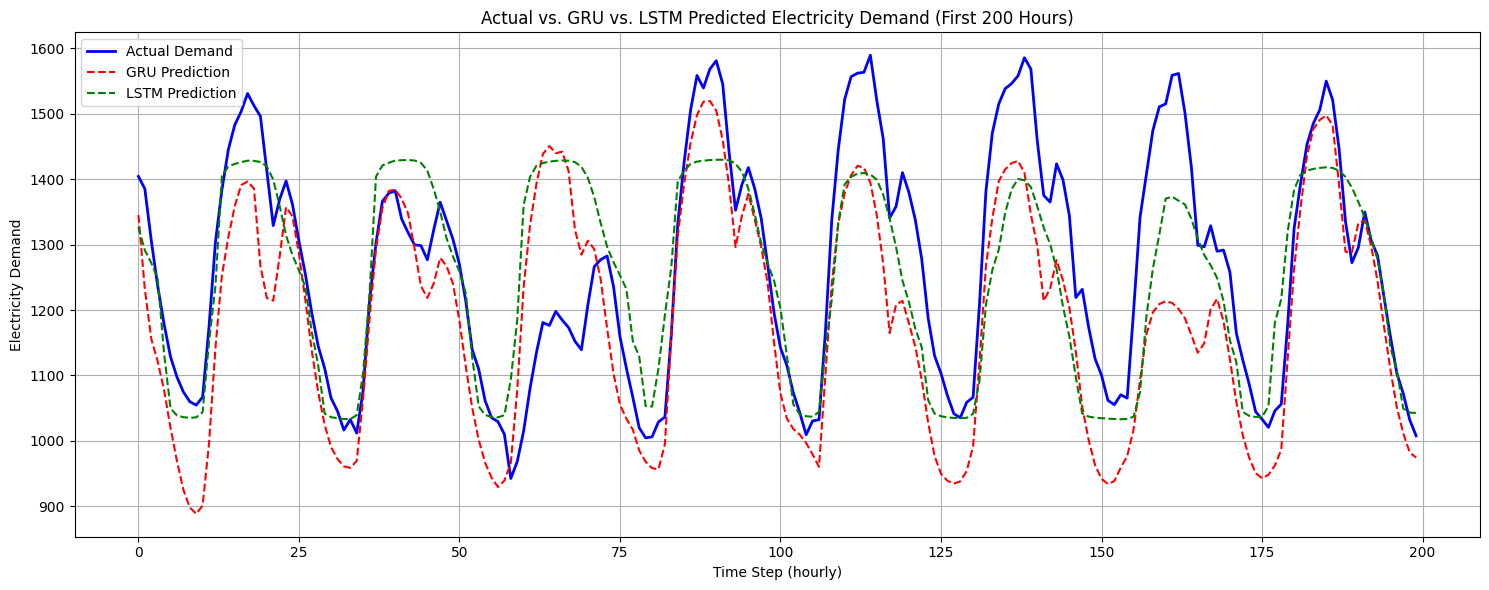

In [37]:
import matplotlib.pyplot as plt

# Plot first 200 test samples
plt.figure(figsize=(15, 6))
plt.plot(actuals[:200], label='Actual Demand', color='blue', linewidth=2)
plt.plot(predictions[:200], label='GRU Prediction', color='red', linestyle='--')
plt.plot(predictions_lstm[:200], label='LSTM Prediction', color='green', linestyle='--')
plt.title('Actual vs. GRU vs. LSTM Predicted Electricity Demand (First 200 Hours)')
plt.xlabel('Time Step (hourly)')
plt.ylabel('Electricity Demand')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()